# A training example in Pytorch
## Introduction
### Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a circle. More precisely, it will be the unity circle in the plane.
![](unitycircle.png)
### Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [3]:
# Generate the data
trainx,trainy = sample_points(10000)
valx,valy = sample_points(500)
testx,testy = sample_points(500)

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (next week you will see how to use BinaryCrossEntropy for such a task).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Note that the optimal accuracy to expect from an hexagone approximating the unity circle is of about **xxxx**. Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than this.

In [4]:
def generate_single_hidden_MLP(n_hidden_neurons):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),nn.ReLU(),nn.Linear(n_hidden_neurons,2))
model1 = generate_single_hidden_MLP(6)

To train our model, we will need to feed it with tensors. Let's transform our generated numpy arrays :

In [5]:
trainx = torch.from_numpy(trainx).float()
valx = torch.from_numpy(valx).float()
testx = torch.from_numpy(testx).float()
trainy = torch.from_numpy(trainy)
valy = torch.from_numpy(valy)
testy = torch.from_numpy(testy)
print(trainx.type(),trainy.type())

torch.FloatTensor torch.LongTensor


Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [6]:
def training_routine(net,dataset,n_iters,gpu):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # use the flag
    train_data,train_labels = train_data,train_labels.long()
    val_data,val_labels = val_data,val_labels.long()
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !
        print("Using GPU")
    else:
        train_data,train_labels = train_data.cpu(),train_labels.cpu()
        val_data,val_labels = val_data.cpu(),val_labels.cpu()
        net = net.cpu() # the network parameters also need to be on the gpu !
        print("Using CPU")
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Once every 100 iterations, print statistics
        if i%100==0:
            print("At iteration",i)
            # compute the accuracy of the prediction
            train_prediction = train_output.cpu().detach().argmax(dim=1)
            train_accuracy = (train_prediction.cpu().numpy()==train_labels.cpu().numpy()).mean() 
            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            # compute the accuracy of the prediction
            val_prediction = val_output.cpu().detach().argmax(dim=1)
            val_accuracy = (val_prediction.cpu().numpy()==val_labels.cpu().numpy()).mean() 
            print("Training loss :",train_loss.cpu().detach().numpy())
            print("Training accuracy :",train_accuracy)
            print("Validation loss :",val_loss.cpu().detach().numpy())
            print("Validation accuracy :",val_accuracy)
    
    net = net.cpu()

In [7]:
dataset = trainx,trainy,valx,valy

In [8]:
gpu =  True
gpu = gpu and torch.cuda.is_available() # to know if you actually can use the GPU

training_routine(model1,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.70178884
Training accuracy : 0.331
Validation loss : 0.7047502
Validation accuracy : 0.324
At iteration 100
Training loss : 0.6872337
Training accuracy : 0.3599
Validation loss : 0.6891359
Validation accuracy : 0.35
At iteration 200
Training loss : 0.6751454
Training accuracy : 0.445
Validation loss : 0.67606694
Validation accuracy : 0.446
At iteration 300
Training loss : 0.6643985
Training accuracy : 0.5902
Validation loss : 0.664555
Validation accuracy : 0.604
At iteration 400
Training loss : 0.65417624
Training accuracy : 0.6238
Validation loss : 0.6536913
Validation accuracy : 0.646
At iteration 500
Training loss : 0.6438489
Training accuracy : 0.6477
Validation loss : 0.64283884
Validation accuracy : 0.674
At iteration 600
Training loss : 0.6329238
Training accuracy : 0.6749
Validation loss : 0.6314514
Validation accuracy : 0.692
At iteration 700
Training loss : 0.62098175
Training accuracy : 0.7178
Validation loss : 0.6190681
Validation 

In [9]:
# Let's try with 3 hidden neurons.
model2 = generate_single_hidden_MLP(3) 
training_routine(model2,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.6626993
Training accuracy : 0.5014
Validation loss : 0.663007
Validation accuracy : 0.482
At iteration 100
Training loss : 0.65249413
Training accuracy : 0.6154
Validation loss : 0.6519072
Validation accuracy : 0.64
At iteration 200
Training loss : 0.6423193
Training accuracy : 0.6571
Validation loss : 0.6410131
Validation accuracy : 0.668
At iteration 300
Training loss : 0.63210577
Training accuracy : 0.6762
Validation loss : 0.6302892
Validation accuracy : 0.696
At iteration 400
Training loss : 0.6218579
Training accuracy : 0.6889
Validation loss : 0.61968905
Validation accuracy : 0.706
At iteration 500
Training loss : 0.6116113
Training accuracy : 0.6986
Validation loss : 0.6093099
Validation accuracy : 0.718
At iteration 600
Training loss : 0.60130554
Training accuracy : 0.7077
Validation loss : 0.5990934
Validation accuracy : 0.726
At iteration 700
Training loss : 0.59091836
Training accuracy : 0.716
Validation loss : 0.5889566
Validation

In [10]:
out = model2(testx).argmax(dim=1).detach().numpy()
green = testx.numpy()[np.where(out==1)]
red = testx.numpy()[np.where(out==0)]
print(green.shape,red.shape)

(235, 2) (265, 2)


In [11]:
def print_model(model,datapoints):
    out = model(datapoints).argmax(dim=1).detach().numpy()
    green = datapoints.numpy()[np.where(out==1)]
    red = datapoints.numpy()[np.where(out==0)]

    circle1 = plt.Circle((0, 0), 1, color='y')
    circle2 = plt.Circle((0, 0), 1, color='b',fill=False)

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
    # fig = plt.gcf()
    # ax = fig.gca()
    plt.xlim((-2,2))
    plt.ylim((-2,2))

    pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
    neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(pos_values)
    ax.add_artist(neg_values)

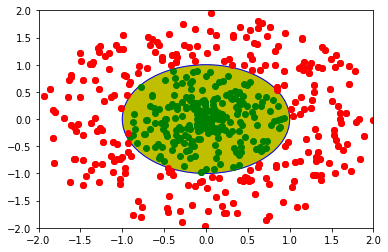

In [12]:
print_model(model1,testx)

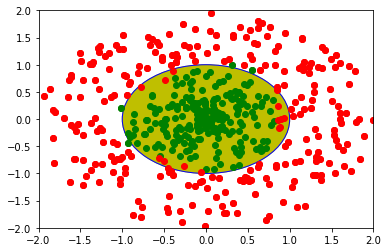

In [13]:
print_model(model2,testx)

In [14]:
model3 = generate_single_hidden_MLP(2) 
training_routine(model3,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.8003798
Training accuracy : 0.4986
Validation loss : 0.7835378
Validation accuracy : 0.518
At iteration 100
Training loss : 0.73373264
Training accuracy : 0.4986
Validation loss : 0.7231694
Validation accuracy : 0.518
At iteration 200
Training loss : 0.70760477
Training accuracy : 0.4986
Validation loss : 0.701147
Validation accuracy : 0.518
At iteration 300
Training loss : 0.6967922
Training accuracy : 0.499
Validation loss : 0.6925845
Validation accuracy : 0.518
At iteration 400
Training loss : 0.69045305
Training accuracy : 0.5348
Validation loss : 0.6873911
Validation accuracy : 0.562
At iteration 500
Training loss : 0.68294394
Training accuracy : 0.5902
Validation loss : 0.680527
Validation accuracy : 0.618
At iteration 600
Training loss : 0.67296565
Training accuracy : 0.6362
Validation loss : 0.6716951
Validation accuracy : 0.636
At iteration 700
Training loss : 0.6634986
Training accuracy : 0.6378
Validation loss : 0.6628508
Validation

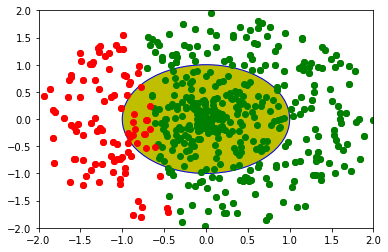

In [15]:
print_model(model3,testx)